<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/scRNA_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of single-cell RNA-seq data of Etv2 induced reprogramming

by Wuming Gong



In [1]:
start_time0 <- Sys.time()

### Install R packages
A large fraction of the running time of this notebook is in installing the Seurat R package, since it has lots of dependencies and many of them use Rcpp which results in the need to compile lots of C++ code.

In [2]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install(c(
  'SummarizedExperiment', 'rhdf5', 'SingleCellExperiment', 'limma', 'goseq', 
  'stringr', 'ggplot2', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db',
  'wordcloud', 'plotrix', 'DESeq2'
), Ncpus = 2)
install.packages(c('farver', "Seurat"), Ncpus = 2)
install.packages('devtools')
devtools::install_github('rstudio/reticulate')

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'SummarizedExperiment', 'rhdf5', 'SingleCellExperiment',
  'limma', 'goseq', 'stringr', 'ggplot2', 'TxDb.Mmusculus.UCSC.mm10.knownGene',
  'org.Mm.eg.db', 'wordcloud', 'plotrix', 'DESeq2'

Old packages: 'broom', 'htmlwidgets', 'readr', 'foreign'

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Skipping install of 'reticulate' from a github remote, the SHA1 (b1604eb2) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
library(SummarizedExperiment)
library(RColorBrewer)
library(plyr)
library(dplyr)
library(parallel)
library(ggplot2)
library(goseq)
library(stringr)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(wordcloud)
library(plotrix)
library(DESeq2)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vecto

## Load processed scRNA-seq data

In [4]:
se <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds')))
table(colData(se)$group)


  MEF_NoDox  MEF_Dox_D1  MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b 
       3562         948        2936        7202         827 

## Determine the number of clusters by running k-means on the scVI latent space

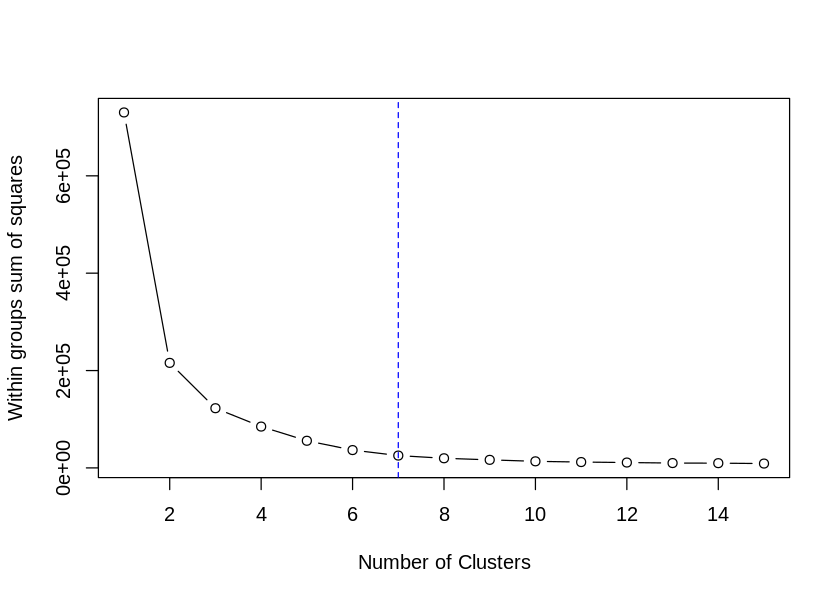

In [5]:
options(repr.plot.width = 10, repr.plot.height = 5)
wss <- (nrow(colData(se)$umap)-1) * sum(apply(colData(se)$umap, 2, var))
for (i in 2:15) wss[i] <- sum(kmeans(colData(se)$umap,centers = i, nstart = 10)$withinss)
options(repr.plot.width=7, repr.plot.height=5)
plot(1:15, wss, type="b", xlab="Number of Clusters", ylab="Within groups sum of squares")
n_cluster <- 7
abline(v = n_cluster, col = 'blue', lty = 2)

In [6]:
set.seed(1)
# it is important to set nstart to a large number to get a relatively robust clustering result. 
cls <- kmeans(colData(se)$umap, n_cluster, nstart = 100)$cluster
table(cls, colData(se)$group)
cls <- as.numeric(factor(cls, c(4, 5, 2, 3, 1, 7, 6)))
table(cls, colData(se)$group)

   
cls MEF_NoDox MEF_Dox_D1 MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b
  1         1          0         17        1493           3
  2         0          6       1443           1           0
  3         0          4       1435          23           0
  4      2878        541         21           2           3
  5       657        381          1           0           0
  6         0          2          0           1         813
  7        26         14         19        5682           8

   
cls MEF_NoDox MEF_Dox_D1 MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b
  1      2878        541         21           2           3
  2       657        381          1           0           0
  3         0          6       1443           1           0
  4         0          4       1435          23           0
  5         1          0         17        1493           3
  6        26         14         19        5682           8
  7         0          2          0           1         813

## UMAP

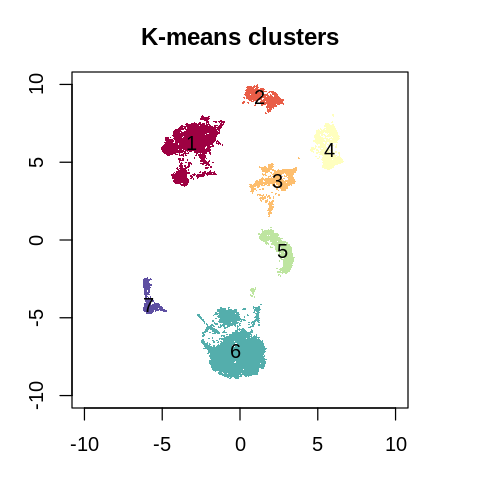

In [7]:
colData(se)$cluster <- cls
group2bg <- c(
   'MEF_NoDox' = 'black',
   'MEF_Dox_D1' = 'blue',
   'MEF_Dox_D2' = 'purple',
   'MEF_Dox_D7a' = 'red',
   'MEF_Dox_D7b' = 'pink'
 )
options(repr.plot.width=4, repr.plot.height=4)
par(mar = c(3, 3, 3, 3))
plot(
   colData(se)$umap,
   col = colorRampPalette(brewer.pal(11,'Spectral'))(n_cluster)[colData(se)$cluster],
   pch = 16, asp = 1, cex = 0.2,
   main = 'K-means clusters', xlab = '', ylab = '',
   xlim = c(-10, 10), ylim = c(-10, 10)
)
y_centers <- do.call('rbind', lapply(1:n_cluster, function(i) apply(colData(se)$umap[colData(se)$cluster == i, ], 2, median)))
text(y_centers[, 1], y_centers[, 2], 1:n_cluster, cex = 1)

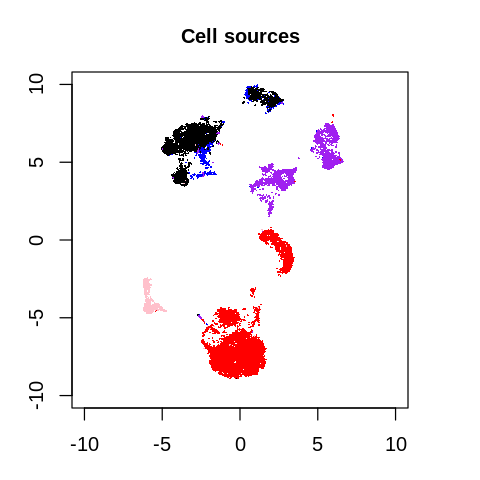

In [8]:
options(repr.plot.width=4, repr.plot.height=4)
par(mar = c(3, 3, 3, 3))
bg <- group2bg[colData(se)$group]
plot(colData(se)$umap, col = bg, asp = 1, pch = 16,  main = 'Cell sources', xlab = '', ylab = '', cex = 0.2, cex.main = 1, cex.axis = 1, xlim = c(-10, 10), ylim = c(-10, 10))

In [9]:
X <- assays(se)$normalized_counts
rownames(X) <- rowData(se)$name
gs <- c(
   'Etv2', 'Emcn', 'Lmo2', 'Kdr', 'Cdh5', 'Smarca4'
)
d <- do.call('rbind', lapply(gs, function(g){
   x <- X[g, ]
   data.frame(
     gene = g, 
     x = colData(se)$umap[, 1], 
     y = colData(se)$umap[, 2], 
     expression = x,
     group = factor(colData(se)$cluster, 1:n_cluster),
     stage = colData(se)$group
   )
}))
head(d)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



,gene,x,y,expression,group,stage
,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,Etv2,-2.4818982,5.426320,0.0000000,1,MEF_Dox_D1
2,Etv2,-2.2740491,5.653505,0.7209901,1,MEF_Dox_D1
3,Etv2,0.9253467,9.236059,0.0000000,2,MEF_Dox_D1
4,Etv2,-2.6293682,-4.882455,0.0000000,6,MEF_Dox_D1
5,Etv2,-2.2673981,6.432043,0.0000000,1,MEF_Dox_D1
6,Etv2,-2.7021725,-4.810947,0.0000000,7,MEF_Dox_D1


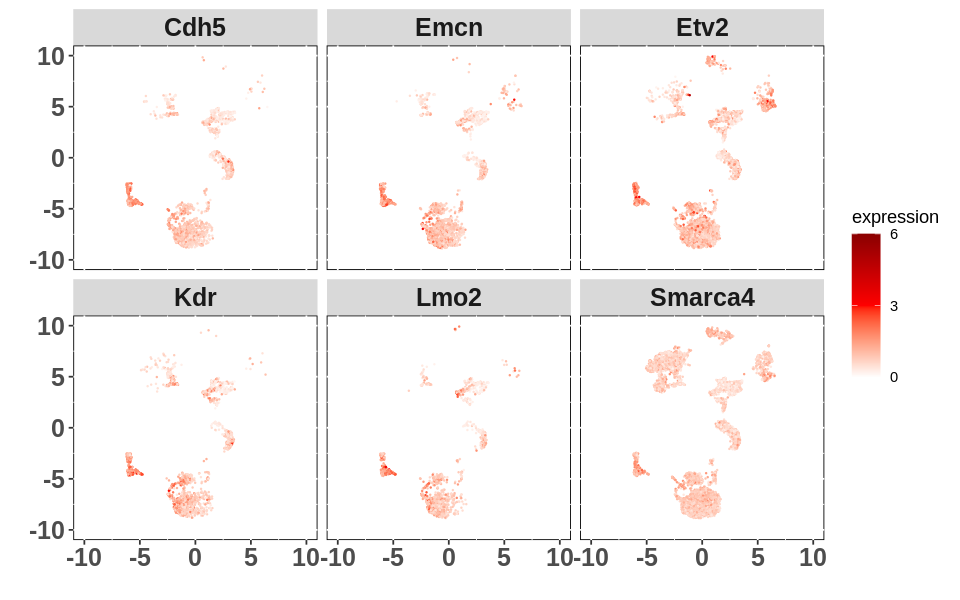

In [10]:
b <- c(0, 3, 6)
options(repr.plot.width=8, repr.plot.height=5)
d %>% 
  filter(expression > 0.1) %>% 
  ggplot(aes(x = x, y = y, color = expression)) + geom_point(size = 0.25, shape = 20) +
    scale_color_gradientn(limits = c(0, max(b)), colours=c("white", "red", "darkred"), breaks=b, labels=format(b)) +
    theme(panel.background = element_rect(fill = 'white', colour = 'black')) +
    xlab('') + ylab('') +
    facet_wrap(~ gene, ncol = 3) +
    theme(strip.text.x = element_text(size = 15, face = 'bold')) +
    theme(axis.text = element_text(size = 15, face = 'bold')) +
    xlim(-10, 10) + ylim(-10, 10)

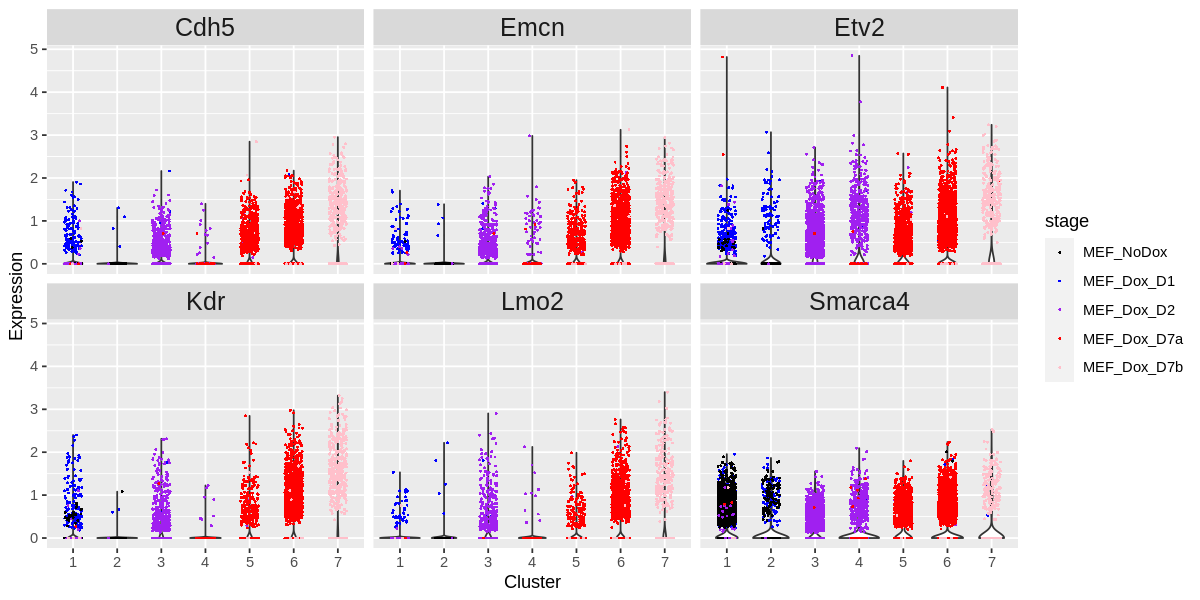

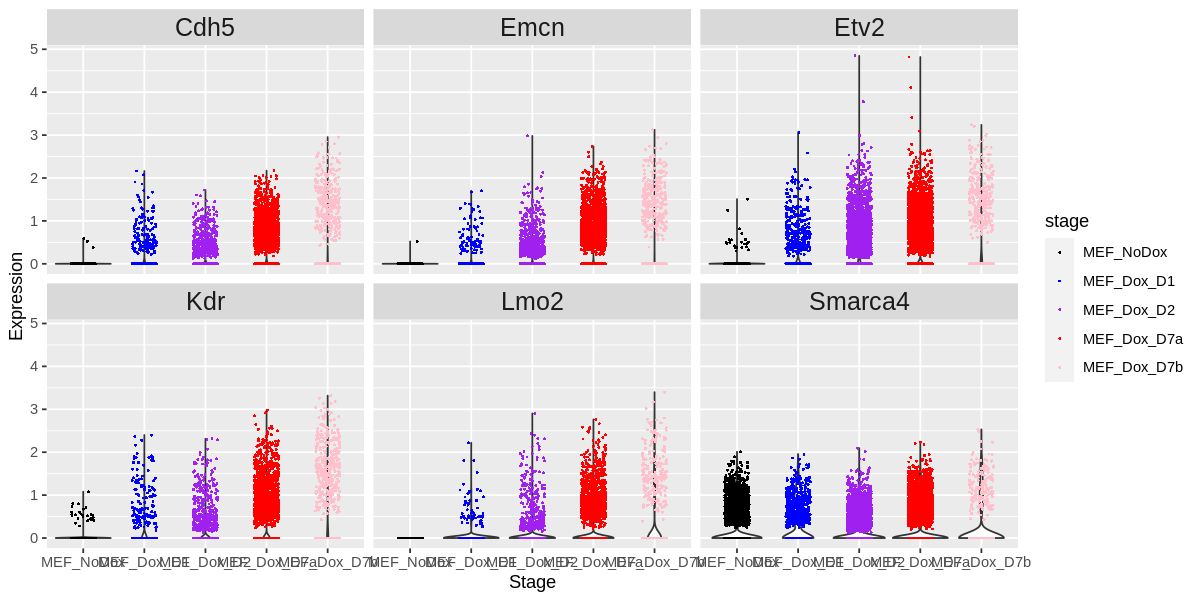

In [11]:
options(repr.plot.width=10, repr.plot.height=5)
d %>%
  ggplot(aes(x = group, y = expression)) + 
  geom_violin() +
  geom_jitter(shape=16, position=position_jitter(0.2), size = 0.5, aes(color = stage)) +
  facet_wrap(~ gene, ncol = 3) +
  scale_color_manual(values=group2bg) +
  theme(strip.text = element_text(size=15)) +
  ylab('Expression') + xlab('Cluster')

options(repr.plot.width=10, repr.plot.height=5)
d %>%
  ggplot(aes(x = stage, y = expression)) + 
  geom_violin() +
  geom_jitter(shape=16, position=position_jitter(0.2), size = 0.5, aes(color = stage)) +
  facet_wrap(~ gene, ncol = 3) +
  scale_color_manual(values=group2bg) +
  theme(strip.text = element_text(size=15)) +
  ylab('Expression') + xlab('Stage')

## Identify the up-regulated genes in cluster 7 (Flk1+) by using t-test on the scaled gene expression levels.



In [12]:
X <- assays(se)$scaled_counts
clust <- colData(se)$cluster
pvalues <- mclapply(
  1:nrow(X), function(i) wilcox.test(X[i, clust == 7], X[i, clust != 7], alternative = 'greater')$p.value,
  mc.cores = 4) %>% unlist()

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



In [13]:
genes <- as.integer(pvalues < 1e-10)
names(genes) <- rowData(se)$name
genes <- genes[!duplicated(names(genes))]
pwf <- nullp(genes, "mm10", "geneSymbol", plot.fit = FALSE)
go_res <- goseq(pwf, "mm10","geneSymbol", test.cats = c("GO:BP"))

Can't find mm10/geneSymbol length data in genLenDataBase...

Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Found the annotation package, TxDb.Mmusculus.UCSC.mm10.knownGene

Trying to get the gene lengths from it.

Fetching GO annotations...

For 2232 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



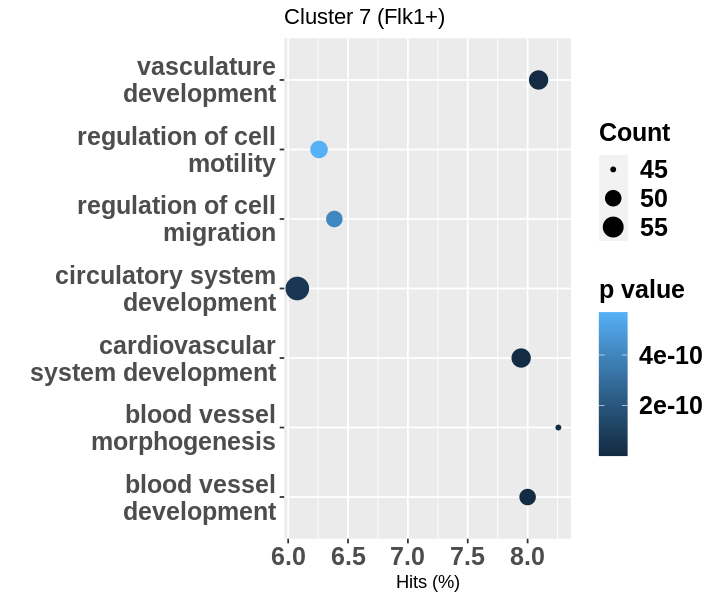

In [14]:
options(repr.plot.width=6, repr.plot.height=5)
go_res %>%
   filter(numInCat < 1000) %>%
   top_n(7, wt = -over_represented_pvalue) %>%
   mutate(hitsPerc = numDEInCat * 100 / numInCat, term = str_wrap(term, 20)) %>%
   ggplot(aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
   geom_point() +
   labs(title = 'Cluster 7 (Flk1+)', x="Hits (%)", y="", colour="p value", size="Count") +
   theme(axis.text = element_text(size = 15, face = 'bold')) +
   theme(legend.text = element_text(size = 15, face = 'bold')) +
   theme(legend.title = element_text(size = 15, face = 'bold')) + 
  scale_color_continuous(breaks = c(2e-10, 4e-10, 6e-10), labels = c('2e-10', '4e-10', '6e-10'))


## Identify the up- and down- regulated genes between cluster 1 (MEF) and cluster 7 (day 7 Flk1+ cells) 


In [15]:
is_cls7 <- clust == 7
is_cls1 <- clust == 1
pvalues_71 <- mclapply(
  1:nrow(X), function(i) wilcox.test(X[i, is_cls7], X[i, is_cls1], alternative = 'two.sided')$p.value,
  mc.cores = 4) %>% unlist()
fc_71 <- rowMeans(X[, is_cls7]) - rowMeans(X[, is_cls1])
names(pvalues_71) <- names(fc_71) <- rowData(se)$name

Generate a vocano plot for differentially expressed genes between MEF and Flk1+ cells at D7

Cd44 is a hematopoietic/fibroblast marker. It looks like Etv2 inhibit the expression of Cd44. We also see this in the EB Etv2 induction data.

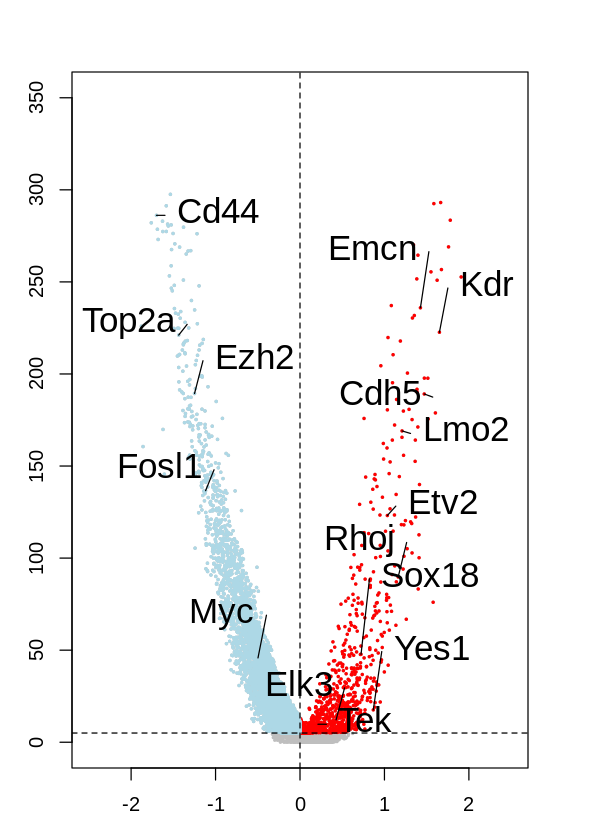

In [16]:
options(repr.plot.width=5, repr.plot.height=7)
par(mar = c(3, 3, 3, 3))
par(xpd = FALSE)
plot(fc_71, -log10(pvalues_71), pch = 21, bg = 'gray', col = 'gray', cex = 0.25, xlim = c(-2.5, 2.5), ylim = c(0, 350))
is_up <- pvalues_71 < 1e-5 & fc_71 > 0
points(fc_71[is_up], -log10(pvalues_71[is_up]), pch = 21, bg = 'red', col = 'red', cex = 0.25)
is_down <- pvalues_71 < 1e-5 & fc_71 < 0
points(fc_71[is_down], -log10(pvalues_71[is_down]), pch = 21, bg = 'lightblue', col = 'lightblue', cex = 0.25)
abline(h = 5, v = 0, lty = 2, col = 'black')
up <- c('Etv2', 'Kdr', 'Emcn', 'Lmo2', 'Cdh5', 'Sox18', 'Tek', 'Elk3', 'Rhoj', 'Yes1')
down <- c('Cd44', 'Myc', 'Fosl1', 'Top2a', 'Ezh2')
gs <- c(up, down)
spread.labels(fc_71[gs], -log10(pvalues_71[gs]), gs, offsets = 0.1, between = FALSE, cex = 1.75)

In [17]:
# Top genes that are up-regulated in cluster 7 vs. cluster 1
data.frame(
  name = rowData(se)$name, 
  fc = fc_71, 
  pvalue = pvalues_71
) %>%
  filter(!is.na(pvalue)) %>% 
  top_n(n = 10, wt = -pvalue)


name,fc,pvalue
<chr>,<dbl>,<dbl>
Col3a1,1.985061,0
Hprt,1.754761,0
Ddah1,-1.747757,0
Ybx1,-1.278268,0
Ptn,1.874753,0
Ifitm2,2.095723,0
Ifitm3,1.749811,0
Hmga2,-1.807456,0
Uba52,1.808543,0


Identifying genes and pathways that are significantly differentially expressed between cluster 1 and 2. MEF and D1 cells are split into two clusters 1 and 2, where in cluster 1 the endothelial genes are activated but not in cluster 2. This pathway analysis is used to investigate what is functional difference between these two clusters

In [18]:
X <- assays(se)$scaled_counts
clust <- colData(se)$cluster
is_cls2 <- clust == 2 & colData(se)$group == 'MEF_NoDox'
is_cls1 <- clust == 1 & colData(se)$group == 'MEF_NoDox'
pvalues_12 <- mclapply(
  1:nrow(X), function(i) wilcox.test(X[i, is_cls2], X[i, is_cls1], alternative = 'two.sided')$p.value,
  mc.cores = 4) %>% unlist()
fc_12 <- rowMeans(X[, is_cls1]) - rowMeans(X[, is_cls2])
names(pvalues_12) <- names(fc_12) <- rowData(se)$name

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



In [19]:
genes <- as.integer(pvalues_12 < 1e-10 & fc_12 > 0)
genes[is.na(genes)] <- 0
names(genes) <- rowData(se)$name
genes <- genes[!duplicated(names(genes))]
pwf <- nullp(genes, "mm10", "geneSymbol", plot.fit = FALSE)
go_res <- goseq(pwf, "mm10","geneSymbol", test.cats = c("GO:BP"))

Can't find mm10/geneSymbol length data in genLenDataBase...

Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Found the annotation package, TxDb.Mmusculus.UCSC.mm10.knownGene

Trying to get the gene lengths from it.

Warning message in pcls(G):
“initial point very close to some inequality constraints”
Fetching GO annotations...

For 2232 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



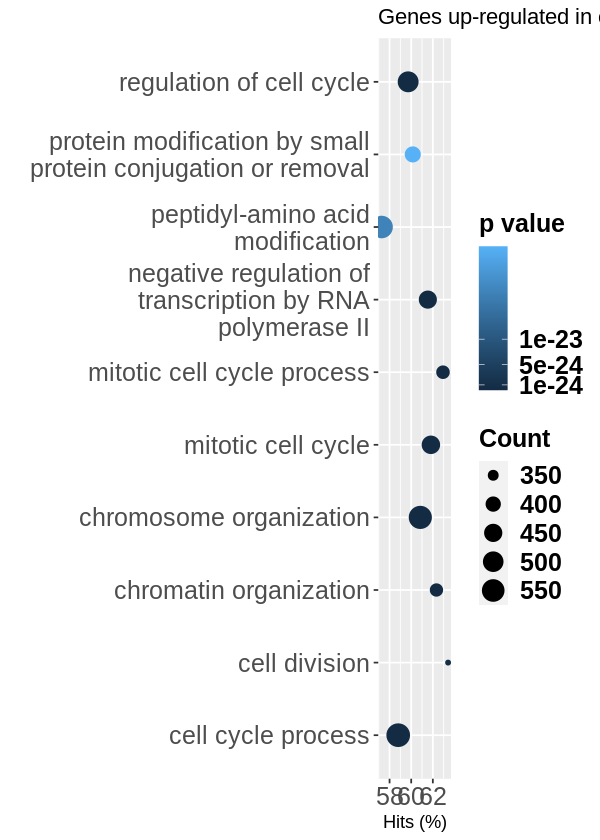

In [20]:
go_res %>%
   filter(numInCat < 1000) %>%
   top_n(10, wt = -over_represented_pvalue) %>%
   mutate(hitsPerc = numDEInCat * 100 / numInCat, term = str_wrap(term, 30)) %>%
   ggplot(aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
   geom_point() +
   labs(title = 'Genes up-regulated in cluster 1', x="Hits (%)", y="", colour="p value", size="Count") +
   theme(axis.text = element_text(size = 15)) +
   theme(legend.text = element_text(size = 15, face = 'bold')) +
   theme(legend.title = element_text(size = 15, face = 'bold')) +
  scale_color_continuous(breaks = c(1e-23, 5e-24, 1e-24))

In [21]:
genes <- as.integer(pvalues_12 < 1e-10 & fc_12 < 0)
genes[is.na(genes)] <- 0
names(genes) <- rowData(se)$name
genes <- genes[!duplicated(names(genes))]
pwf <- nullp(genes, "mm10", "geneSymbol", plot.fit = FALSE)
go_res <- goseq(pwf, "mm10","geneSymbol", test.cats = c("GO:BP"))

Can't find mm10/geneSymbol length data in genLenDataBase...

Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Found the annotation package, TxDb.Mmusculus.UCSC.mm10.knownGene

Trying to get the gene lengths from it.

Fetching GO annotations...

For 2232 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



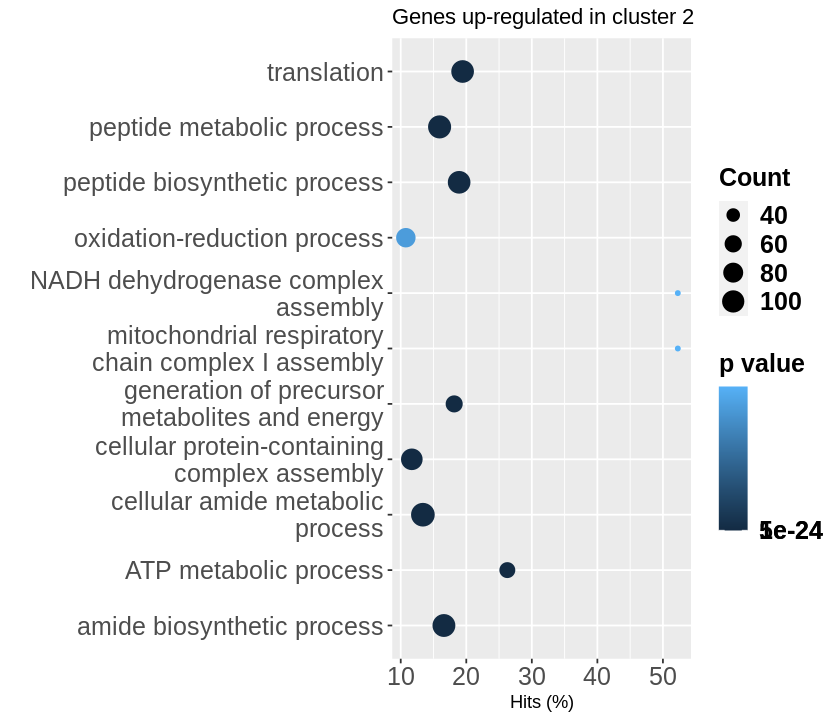

In [22]:
options(repr.plot.width=7, repr.plot.height=6)
go_res %>%
   filter(numInCat < 1000) %>%
   top_n(10, wt = -over_represented_pvalue) %>%
   mutate(hitsPerc = numDEInCat * 100 / numInCat, term = str_wrap(term, 30)) %>%
   ggplot(aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
   geom_point() +
   labs(title = 'Genes up-regulated in cluster 2', x="Hits (%)", y="", colour="p value", size="Count") +
   theme(axis.text = element_text(size = 15)) +
   theme(legend.text = element_text(size = 15, face = 'bold')) +
   theme(legend.title = element_text(size = 15, face = 'bold')) +
  scale_color_continuous(breaks = c(5e-24, 1e-24))


## Top genes that are up-regulated in cluster 1 vs. cluster 2

In [23]:
data.frame(
  name = rowData(se)$name, 
  fc = fc_12, 
  pvalue = pvalues_12
) %>%
  filter(!is.na(pvalue) & fc > 0) %>% 
  top_n(n = 10, wt = -pvalue)

name,fc,pvalue
<chr>,<dbl>,<dbl>
Col5a2,1.882654,7.142507e-280
Fn1,2.101424,0.000000e+00
Col1a2,2.232254,0.000000e+00
Fbln2,2.219038,0.000000e+00
Ybx3,1.877012,1.746946e-279
Ckap4,1.810292,5.611045e-287
Hsp90b1,1.910358,1.854136e-282
Sparc,1.726337,5.537022e-287
Ltbp1,2.052170,8.824864e-287


In [24]:
X <- assays(se)$normalized_counts
rownames(X) <- rowData(se)$name
gs <- c(
   'Etv2', 'Ccnd1', 'Kdr', 'Ezh2', 'Fn1', 'Cd44', 'Smarca4'
)
d <- do.call('rbind', lapply(gs, function(g){
   x <- X[g, ]
   data.frame(
     gene = g, 
     expression = x,
     group = factor(colData(se)$cluster, 1:n_cluster),
     stage = colData(se)$group
   )
}))
head(d)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



,gene,expression,group,stage
,<chr>,<dbl>,<fct>,<fct>
1,Etv2,0.0000000,1,MEF_Dox_D1
2,Etv2,0.7209901,1,MEF_Dox_D1
3,Etv2,0.0000000,2,MEF_Dox_D1
4,Etv2,0.0000000,6,MEF_Dox_D1
5,Etv2,0.0000000,1,MEF_Dox_D1
6,Etv2,0.0000000,7,MEF_Dox_D1


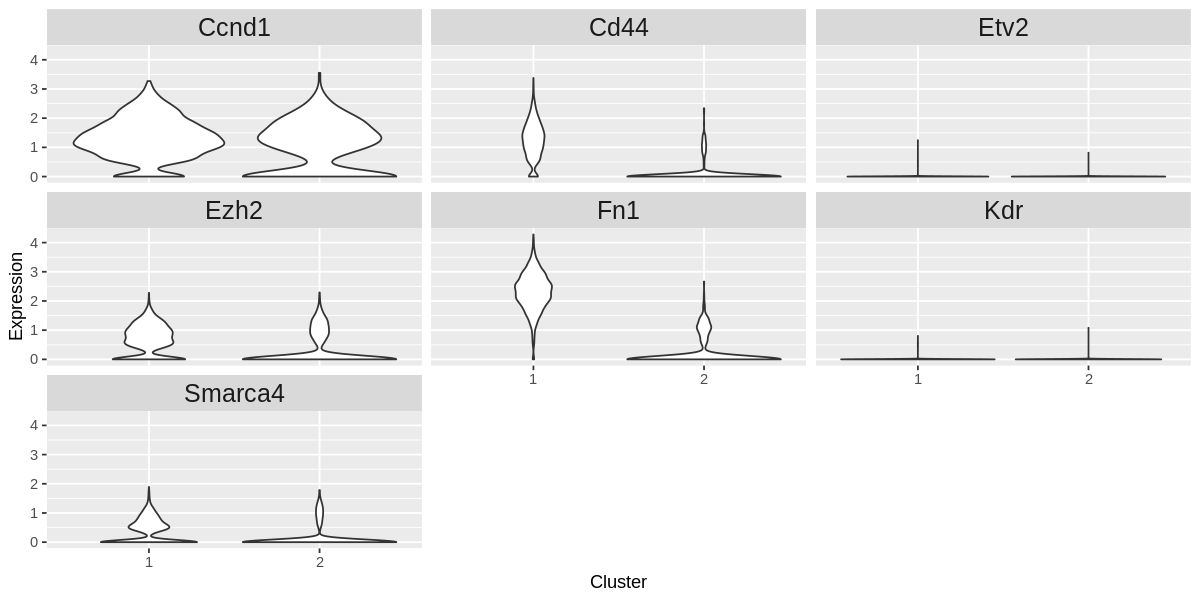

In [25]:
options(repr.plot.width=10, repr.plot.height=5)
d %>%
  filter(stage == 'MEF_NoDox' & group %in% c(1,2)) %>%
  ggplot(aes(x = group, y = expression)) + 
  geom_violin() +
#  geom_jitter(shape=16, position=position_jitter(0.2), size = 0.5, aes(color = stage)) +
  facet_wrap(~ gene, ncol = 3) +
  scale_color_manual(values=group2bg) +
  theme(strip.text = element_text(size=15)) +
  ylab('Expression') + xlab('Cluster')

## Load the bulk RNA-seq of Etv2 induction in ES/EB.

In [26]:
se_rna <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2RNA-seq_version=20190909a/se.rds')))
se_rna <- DESeqDataSet(se_rna, design = ~ group)
se_rna <- estimateSizeFactors(se_rna)
se_rna <- DESeq(se_rna)
assays(se_rna)$normalized_counts <- log2(counts(se_rna, normalized = TRUE) + 1)
table(colData(se_rna)$group)
res <- results(se_rna, contrast = c('group', 'EB_Dox_D25_Flk1pos_Etv2', 'EB_NoDox_D25_Etv2'))

Warning message in DESeqDataSet(se_rna, design = ~group):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




         EB_Dox_D2_Etv2         EB_Dox_D25_Etv2 EB_Dox_D25_Flk1pos_Etv2 
                      2                       2                       2 
       EB_NoDox_D2_Etv2       EB_NoDox_D25_Etv2 
                      2                       2 

## Merge the scRNA-seq and bulk RNA-seq by gene symbols

In [27]:
y <- merge(
  data.frame(symbol = rownames(res), EB_log2FoldChange = res$log2FoldChange, EB_pvalue = res$pvalue),
  data.frame(symbol = rowData(se)$name, MEF_log2FoldChange = fc_71, MEF_pvalue = pvalues_71),
  by.x = 'symbol',
  by.y = 'symbol'
) %>%
  filter(!is.na(EB_pvalue) & !is.na(MEF_pvalue)) %>%
  filter(!duplicated(symbol))
rownames(y) <- y$symbol
y %>% filter(symbol %in% c('Etv2', 'Kdr', 'Emcn', 'Cdh5', 'Runx1'))

,symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cdh5,Cdh5,7.534863,1.315189e-43,1.4715315,7.480613e-190
Emcn,Emcn,5.908320,6.634402e-03,1.4261455,1.144997e-236
Etv2,Etv2,5.462880,0.000000e+00,1.0342890,7.375372e-124
Kdr,Kdr,7.093824,0.000000e+00,1.6510391,2.300831e-223
Runx1,Runx1,1.891086,1.139845e-11,-0.4714413,3.180546e-34


In [28]:
up_in_EB <- y %>% filter(EB_pvalue < 1e-3 & EB_log2FoldChange > 0) 
up_in_MEF <- y %>% filter(MEF_pvalue < 1e-3 & MEF_log2FoldChange > 0)
up_in_both <- y %>% filter(EB_pvalue < 1e-3 & MEF_pvalue < 1e-3 & EB_log2FoldChange > 0 & MEF_log2FoldChange > 0) 
cat(sprintf('up-regulated genes in EB: %s\n', nrow(up_in_EB)))
cat(sprintf('up-regulated genes only in EB: %s\n', nrow(up_in_EB) - nrow(up_in_both)))
cat(sprintf('up-regulated genes in MEF: %s\n', nrow(up_in_MEF)))
cat(sprintf('up-regulated genes only in MEF: %s\n', nrow(up_in_MEF) - nrow(up_in_both)))
cat(sprintf('up-regulated genes in both MEF and EB: %s\n', nrow(up_in_both)))

up-regulated genes in EB: 2324
up-regulated genes only in EB: 1770
up-regulated genes in MEF: 1896
up-regulated genes only in MEF: 1342
up-regulated genes in both MEF and EB: 554


In [29]:
down_in_EB <- y %>% filter(EB_pvalue < 1e-3 & EB_log2FoldChange < 0)
down_in_MEF <- y %>% filter(MEF_pvalue < 1e-3 & MEF_log2FoldChange < 0)
down_in_both <- y %>% filter(EB_pvalue < 1e-3 & MEF_pvalue < 1e-3 & EB_log2FoldChange < 0 & MEF_log2FoldChange < 0)
cat(sprintf('down-regulated genes in EB: %s\n', nrow(down_in_EB)))
cat(sprintf('down-regulated genes only in EB: %s\n', nrow(down_in_EB) - nrow(down_in_both)))
cat(sprintf('down-regulated genes in MEF: %s\n', nrow(down_in_MEF)))
cat(sprintf('down-regulated genes only in MEF: %s\n', nrow(down_in_MEF) - nrow(down_in_both)))
cat(sprintf('down-regulated genes in both MEF and EB: %s\n', nrow(down_in_both)))

down-regulated genes in EB: 2328
down-regulated genes only in EB: 821
down-regulated genes in MEF: 6389
down-regulated genes only in MEF: 4882
down-regulated genes in both MEF and EB: 1507


## Pathway analysis of commonly up-regulated genes in MEF and EB


In [30]:
genes <- as.integer(y$EB_pvalue < 1e-3 & y$MEF_pvalue < 1e-3 & y$EB_log2FoldChange > 0 & y$MEF_log2FoldChange > 0)
genes[is.na(genes)] <- 0
names(genes) <- y$symbol
genes <- genes[!duplicated(names(genes))]
pwf <- nullp(genes, "mm10", "geneSymbol", plot.fit = FALSE)
go_res <- goseq(pwf, "mm10","geneSymbol", test.cats = c("GO:BP"))

Can't find mm10/geneSymbol length data in genLenDataBase...

Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Found the annotation package, TxDb.Mmusculus.UCSC.mm10.knownGene

Trying to get the gene lengths from it.

Warning message in pcls(G):
“initial point very close to some inequality constraints”
Fetching GO annotations...

For 410 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



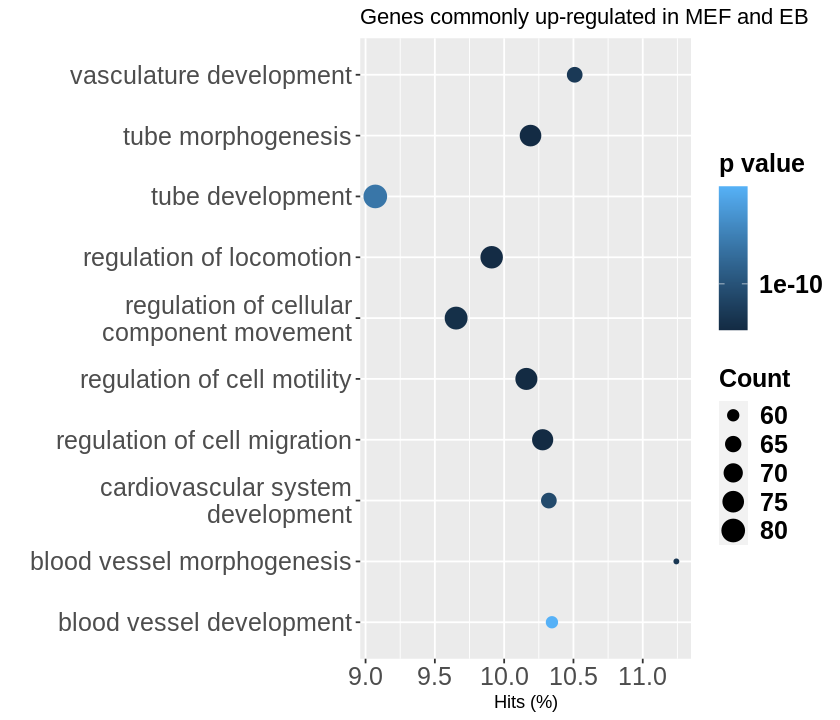

In [31]:
options(repr.plot.width=7, repr.plot.height=6)
go_res %>%
   filter(numInCat < 1000) %>%
   top_n(10, wt = -over_represented_pvalue) %>%
   mutate(hitsPerc = numDEInCat * 100 / numInCat, term = str_wrap(term, 30)) %>%
   ggplot(aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
   geom_point() +
   labs(title = 'Genes commonly up-regulated in MEF and EB', x="Hits (%)", y="", colour="p value", size="Count") +
   theme(axis.text = element_text(size = 15)) +
   theme(legend.text = element_text(size = 15, face = 'bold')) +
   theme(legend.title = element_text(size = 15, face = 'bold')) + 
  scale_color_continuous(breaks = c(5e-10, 1e-10))

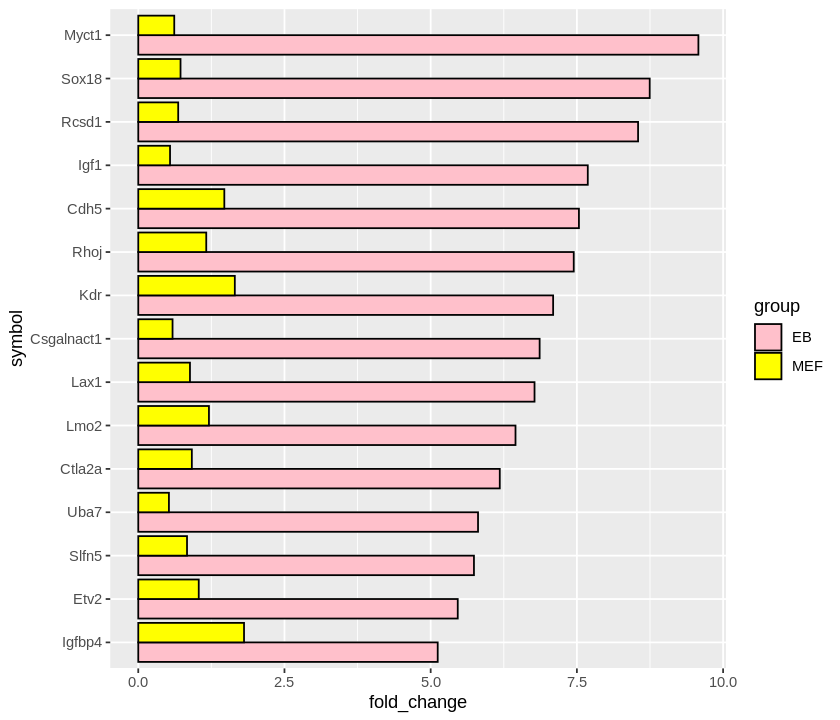

In [32]:
y2 <- y %>%
  filter(EB_pvalue < 1e-3 & MEF_pvalue < 1e-3 & EB_log2FoldChange > 0.5 & MEF_log2FoldChange > 0.5) %>%
  arrange(-EB_log2FoldChange) %>%
  head(15) %>%
  mutate(symbol = factor(symbol, rev(symbol)))

rbind(
  data.frame(symbol = y2$symbol, fold_change = y2$EB_log2FoldChange, group = 'EB'),
  data.frame(symbol = y2$symbol, fold_change = y2$MEF_log2FoldChange, group = 'MEF')
) %>%
  ggplot(aes(x = symbol, y = fold_change, fill = group)) +
  geom_bar(stat="identity", color="black", position=position_dodge()) +
  scale_fill_manual(values = c('pink', 'yellow')) +
  coord_flip()

## Pathway analysis of commonly down-regulated genes in MEF and EB

In [33]:
genes <- as.integer(y$EB_pvalue < 1e-3 & y$MEF_pvalue < 1e-3 & y$EB_log2FoldChange < 0 & y$MEF_log2FoldChange < 0)
genes[is.na(genes)] <- 0
names(genes) <- y$symbol
genes <- genes[!duplicated(names(genes))]
pwf <- nullp(genes, "mm10", "geneSymbol", plot.fit = FALSE)
go_res <- goseq(pwf, "mm10","geneSymbol", test.cats = c("GO:BP"))

Can't find mm10/geneSymbol length data in genLenDataBase...

Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Found the annotation package, TxDb.Mmusculus.UCSC.mm10.knownGene

Trying to get the gene lengths from it.

Fetching GO annotations...

For 410 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



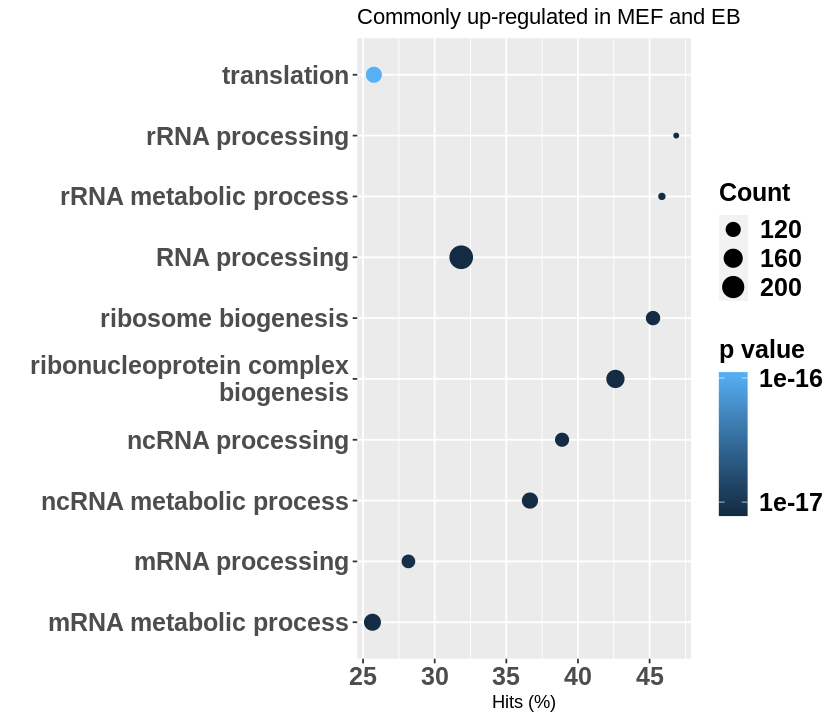

In [34]:
options(repr.plot.width=7, repr.plot.height=6)
go_res %>%
   filter(numInCat < 1000) %>%
   top_n(10, wt = -over_represented_pvalue) %>%
   mutate(hitsPerc = numDEInCat * 100 / numInCat, term = str_wrap(term, 30)) %>%
   ggplot(aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
   geom_point() +
   labs(title = 'Commonly up-regulated in MEF and EB', x="Hits (%)", y="", colour="p value", size="Count") +
   theme(axis.text = element_text(size = 15, face = 'bold')) +
   theme(legend.text = element_text(size = 15, face = 'bold')) +
   theme(legend.title = element_text(size = 15, face = 'bold')) +
  scale_color_continuous(breaks = c(1e-16, 1e-17))

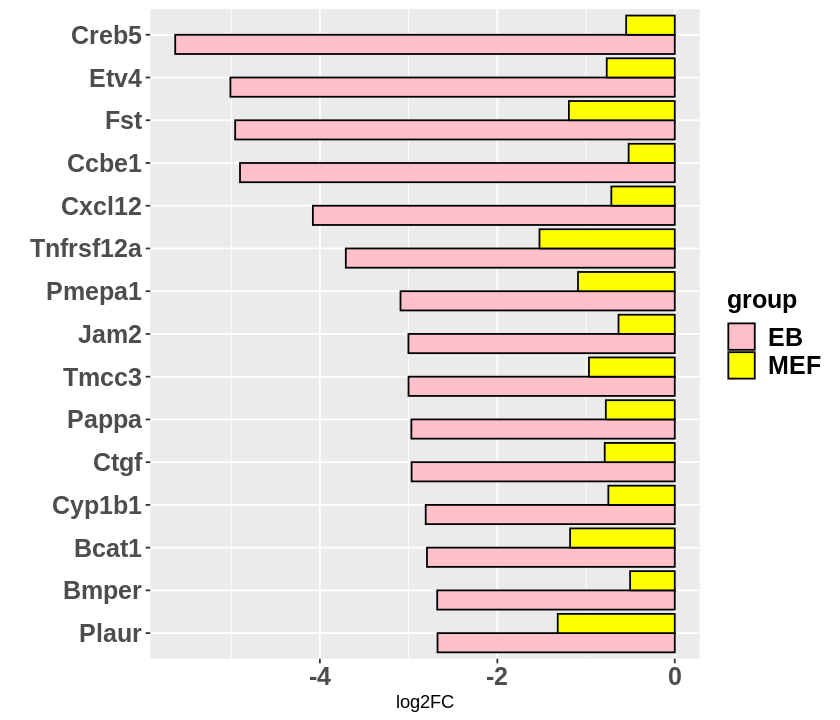

In [35]:
y2 <- y %>%
  filter(EB_pvalue < 1e-3 & MEF_pvalue < 1e-3 & EB_log2FoldChange < -0.5 & MEF_log2FoldChange < -0.5) %>%
  arrange(EB_log2FoldChange) %>%
  head(15) %>%
  mutate(symbol = factor(symbol, rev(symbol)))

rbind(
  data.frame(symbol = y2$symbol, fold_change = y2$EB_log2FoldChange, group = 'EB'),
  data.frame(symbol = y2$symbol, fold_change = y2$MEF_log2FoldChange, group = 'MEF')
) %>%
  ggplot(aes(x = symbol, y = fold_change, fill = group)) +
  geom_bar(stat="identity", color="black", position=position_dodge()) +
  scale_fill_manual(values = c('pink', 'yellow')) +
  coord_flip() +
  theme(axis.text = element_text(size = 15, face = 'bold')) +
  theme(legend.text = element_text(size = 15, face = 'bold')) +
  theme(legend.title = element_text(size = 15, face = 'bold')) +
  xlab('') + ylab('log2FC')

In [36]:
Sys.time() - start_time0

Time difference of 10.66397 mins

In [37]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] DESeq2_1.28.1                            
 [2] plotrix_3.7-8                            
 [3] wordcloud_2.6                            
 [4] org.Mm.eg.db_3.11.4                      
 [5] TxDb.Mmusculus.UCSC.mm10.knownGene_3.10.0
 [6] Genomi